In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
from keras import backend as K
from keras.models import load_model
from keras.preprocessing.image import img_to_array
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [22]:
from keras.applications.vgg19 import VGG19
from matplotlib import pyplot
import numpy as np

In [23]:
def read_data(path):
    
    train_path = path+"/train"
    test_path = path+"/test"
    validation_path = path+"/val"
    
    tr_data, test_data, val_data = [], [], []
    tr_out, test_out, val_out = [], [], []

    for i in os.listdir(train_path):
        try:
            for j in os.listdir(train_path+"/"+i):
                image = cv2.imread(train_path+"/"+i+"/"+j) #COLOR_BGR2RGB
                tr_data.append(cv2.resize(image, (224, 224)))
                tr_out.append(i)

            for j in os.listdir(test_path+"/"+i):
                image = cv2.imread(test_path+"/"+i+"/"+j)
                test_data.append(cv2.resize(image, (224, 224)))
                test_out.append(i)

            for j in os.listdir(validation_path+"/"+i):
                image = cv2.imread(validation_path+"/"+i+"/"+j)
                val_data.append(cv2.resize(image, (224, 224)))
                val_out.append(i)
        except:
            pass
                
    tr_data, test_data, val_data = np.array(tr_data), np.array(test_data), np.array(val_data)
    return tr_data, test_data, val_data, tr_out, test_out, val_out

def label_data(x):
    label = []
    for i in x:
        if i =='chandelier':
            label.append(0)
        if i =='ketch':
            label.append(1)
        if i =='bonsai':
            label.append(2)
    return label

path = "/Users/rajeshr/Desktop/Group_22"
tr_data, test_data, val_data, tr_out, test_out, val_out = read_data(path)

test_label = np.array(label_data(test_out))
tr_label = np.array(label_data(tr_out))
val_label = np.array(label_data(val_out))

#### SELECTED IMAGES 
path = '/Users/rajeshr/Desktop/Group_22/selected/'
images = []
color_images = []
label = []
for i in os.listdir(path):
    image = cv2.imread(path+i, cv2.IMREAD_GRAYSCALE)
    color_image = cv2.imread(path+i, cv2.COLOR_BGR2RGB)
    try:
        images.append(cv2.resize(image, (224, 224)))
        color_images.append(cv2.resize(color_image, (224, 224)))
        label.append(i)
    except:
        pass
    
images = np.array(images)
label = np.array(label)
color_images = np.array(color_images)
labels = np.arange(0, len(label))

In [4]:
IMG_SHAPE  = 224
batch_size = 32

In [6]:
# load vgg model
# load the model
model = VGG19()
# summarize the model
#model.summary()

In [7]:
# summarize filters in each convolutional layer
# load the model
# summarize filter shapes
for layer in model.layers:
    # check for convolutional layer
    if 'conv' not in layer.name:
        continue
    # get filter weights
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

block1_conv1 (3, 3, 3, 64)
block1_conv2 (3, 3, 64, 64)
block2_conv1 (3, 3, 64, 128)
block2_conv2 (3, 3, 128, 128)
block3_conv1 (3, 3, 128, 256)
block3_conv2 (3, 3, 256, 256)
block3_conv3 (3, 3, 256, 256)
block3_conv4 (3, 3, 256, 256)
block4_conv1 (3, 3, 256, 512)
block4_conv2 (3, 3, 512, 512)
block4_conv3 (3, 3, 512, 512)
block4_conv4 (3, 3, 512, 512)
block5_conv1 (3, 3, 512, 512)
block5_conv2 (3, 3, 512, 512)
block5_conv3 (3, 3, 512, 512)
block5_conv4 (3, 3, 512, 512)


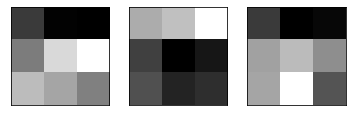

In [11]:
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
# plot first few filters
n_filters, ix = 1, 1
for i in range(n_filters):
    # get the filter
    f = filters[:, :, :, i]
    # plot each channel separately
    for j in range(3):
        # specify subplot and turn of axis
        ax = pyplot.subplot(n_filters, 3, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
        pyplot.imshow(f[:, :, j], cmap='gray')
        ix += 1
    # show the figure
pyplot.show()

In [43]:
pre_trained_model = tf.keras.applications.VGG19(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
#pre_trained_model.summary()

In [44]:
for layer in pre_trained_model.layers:
    #print(layer.name)
    layer.trainable = False

In [45]:
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [46]:
x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

In [47]:
model = tf.keras.Model(pre_trained_model.input, x)

In [48]:
model.compile(optimizer='adam', loss=tf.keras.losses.categorical_crossentropy, metrics=['acc'])

In [42]:
image_gen_train = ImageDataGenerator(rescale = 1./255)
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size, 
                                                     directory = '/Users/rajeshr/Desktop/Group_22/train',
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                     class_mode = 'categorical')

image_generator_validation = ImageDataGenerator(rescale=1./255)
val_data_gen = image_generator_validation.flow_from_directory(batch_size=batch_size,
                                                              directory='/Users/rajeshr/Desktop/Group_22/val',
                                                              target_size=(IMG_SHAPE, IMG_SHAPE),
                                                              class_mode='categorical')
image_gen_test = ImageDataGenerator(rescale=1./255)
test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory='/Users/rajeshr/Desktop/Group_22/test',
                                                   target_size=(IMG_SHAPE, IMG_SHAPE),
                                                   class_mode='categorical')

Found 150 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [50]:
vgg_classifier = model.fit(train_data_gen,
                 steps_per_epoch=(len(tr_data)//batch_size),
                 epochs = 25,
                 validation_data=val_data_gen,
                 validation_steps=(len(val_data)//batch_size),
                 batch_size = batch_size,
                 verbose = 1)

Epoch 1/25
4/4 [==============================] - 17s 4s/step - loss: 0.0199 - acc: 1.0000
Epoch 2/25
4/4 [==============================] - 18s 4s/step - loss: 0.0117 - acc: 1.0000
Epoch 3/25
4/4 [==============================] - 18s 4s/step - loss: 0.0148 - acc: 1.0000
Epoch 4/25
4/4 [==============================] - 18s 5s/step - loss: 0.0162 - acc: 1.0000
Epoch 5/25
4/4 [==============================] - 18s 4s/step - loss: 0.0169 - acc: 1.0000
Epoch 6/25
4/4 [==============================] - 19s 5s/step - loss: 0.0191 - acc: 1.0000
Epoch 7/25
4/4 [==============================] - 20s 5s/step - loss: 0.0083 - acc: 1.0000
Epoch 8/25
4/4 [==============================] - 19s 5s/step - loss: 0.0145 - acc: 1.0000
Epoch 9/25
4/4 [==============================] - 20s 5s/step - loss: 0.0122 - acc: 1.0000
Epoch 10/25
4/4 [==============================] - 19s 5s/step - loss: 0.0106 - acc: 1.0000
Epoch 11/25
4/4 [==============================] - 19s 5s/step - loss: 0.0127 - acc: 1.00

In [51]:
result = model.evaluate(test_data_gen,batch_size=batch_size)
print("test_loss, test accuracy",result)

2/2 [==============================] - 8s 4s/step - loss: 0.0220 - acc: 1.0000
test_loss, test accuracy [0.02201954834163189, 1.0]


In [52]:
model_json = model.to_json()
with open("/Users/rajeshr/JupyterNotebooks/DeepLearning/A3/VGG_Caltech_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save("/Users/rajeshr/JupyterNotebooks/DeepLearning/A3/VGG_Caltech_Classifier.h5")
print("Saved model to disk")
model.save_weights("/Users/rajeshr/JupyterNotebooks/DeepLearning/A3/VGG_Caltech.h5")

Saved model to disk
